# **Imports**

In [379]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, plot_precision_recall_curve, precision_recall_fscore_support, average_precision_score, plot_roc_curve, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Load file**

In [238]:
data = fetch_openml('credit-g')
X = data.data
y = data.target

In [239]:
X.shape, y.shape

((1000, 20), (1000,))

In [240]:
X.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,4.0,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,2.0,real estate,22.0,none,own,1.0,skilled,1.0,none,yes
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,3.0,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,4.0,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,4.0,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes


# **Q1.**
## Determine which features are continuous and which are categorical.

In [241]:
XDtype = X.dtypes == float
indxes_cont = [indx for indx, i in enumerate(XDtype) if i == True]
indxes_cate = [indx for indx, i in enumerate(XDtype) if i == False]

In [242]:
# A1
continuous = X.columns[indxes_cont]
categorical = X.columns[indxes_cate]
print("continuous features : "+", ".join(continuous))
print("categorical features : "+", ".join(categorical))

continuous features : duration, credit_amount, installment_commitment, residence_since, age, existing_credits, num_dependents
categorical features : checking_status, credit_history, purpose, savings_status, employment, personal_status, other_parties, property_magnitude, other_payment_plans, housing, job, own_telephone, foreign_worker


# **Q2.**
## Visualize the univariate distribution of each continuous feature, and the distribution of the target.

the univariate distribution of each continuous feature

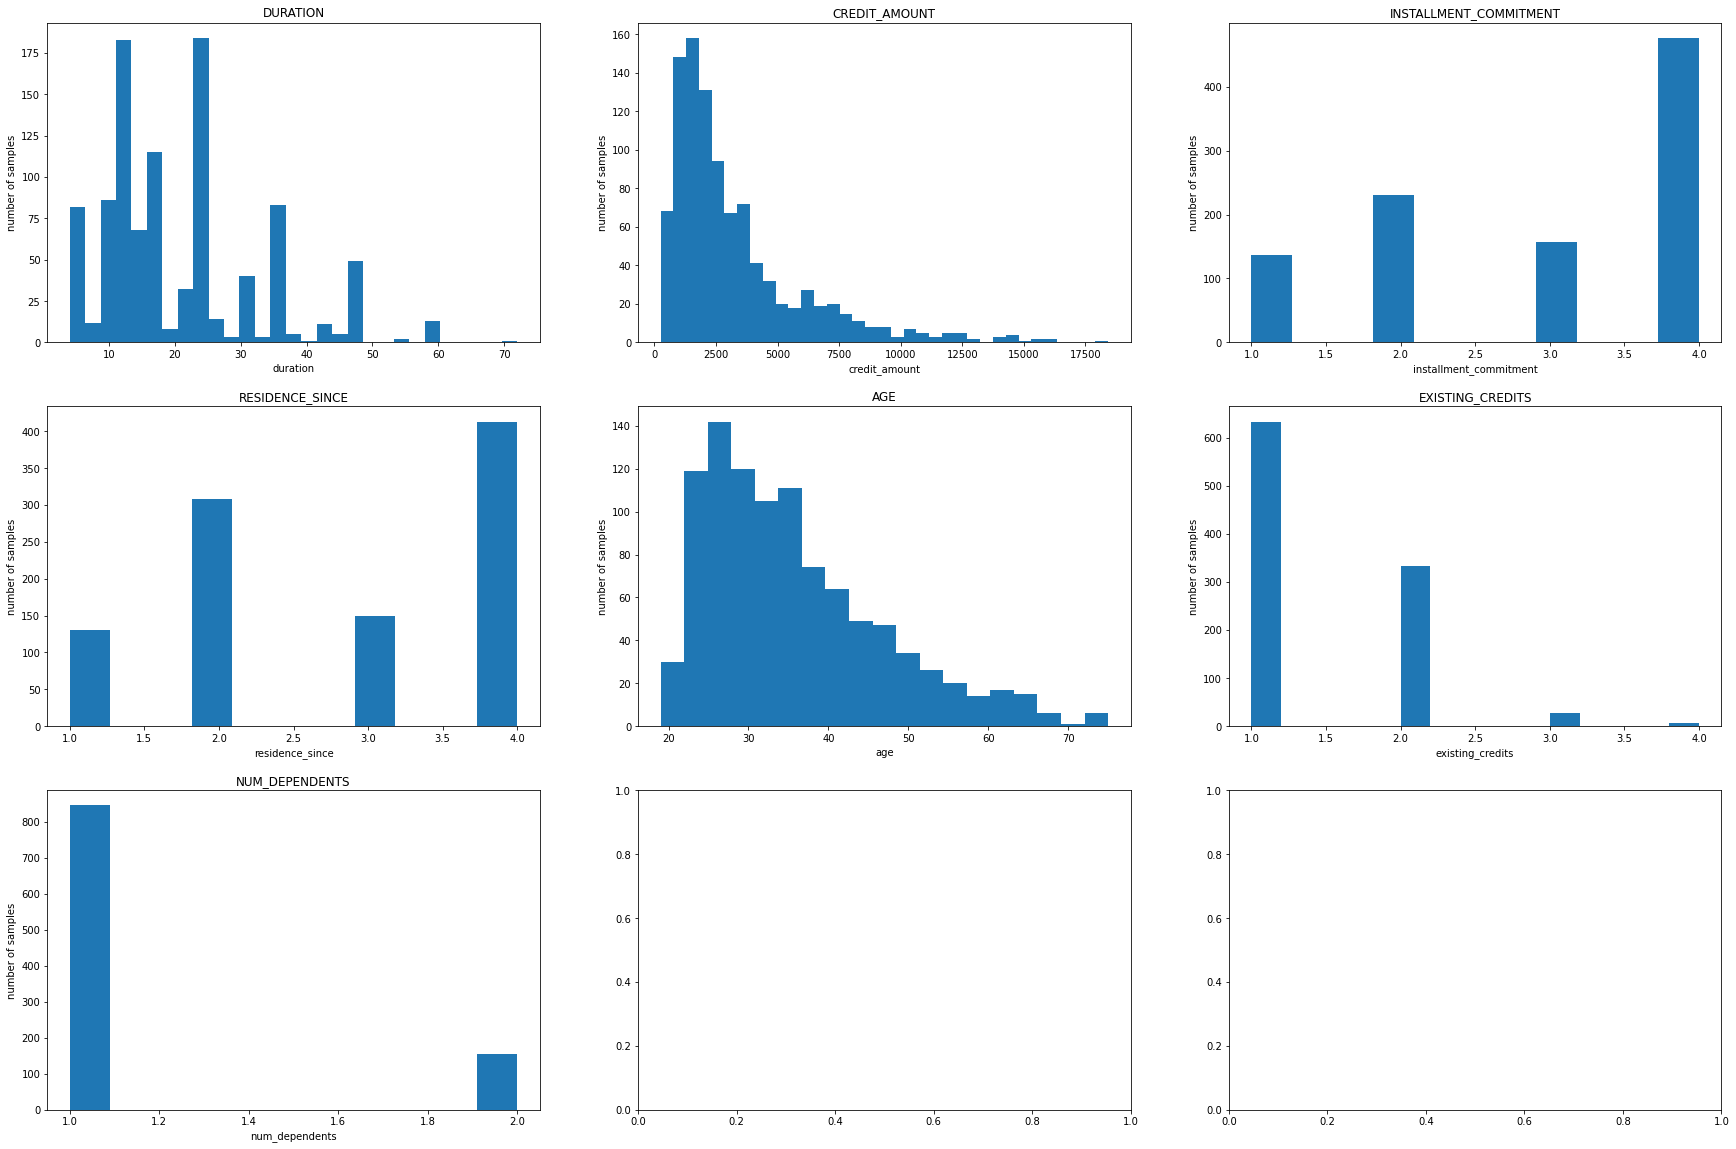

In [244]:
figs, axes = plt.subplots(3, 3, figsize = (30, 20))
for i, ax in enumerate(axes.ravel()):
    if i > continuous.size - 1:
        break 
    
    ax.hist(X[continuous[i]], bins='auto')
    ax.set_title(continuous[i].upper())
    ax.set_xlabel(continuous[i])
    ax.set_ylabel('number of samples')    

the distribution of the target

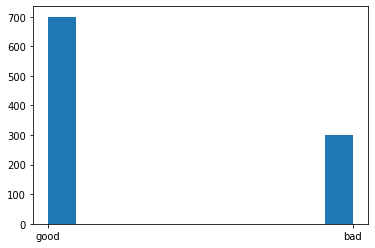

In [245]:
plt.hist(y, bins='auto')
plt.show()

# **Q3.**
## Split data into training (70%), validation (10%), and test set (20%). 
## Do not use the test set until a final evaluation in 5.
## Preprocess the data without using a pipeline and evaluate an initial Logistic Regression model with the training and validation split.


In [246]:
# 0, 1로 mapping 되는 categorical features들은 label encoding
# 3개 이상의 정수로 mapping 되는 features들은 더미화 한다.

def category_encoding(data, category):
    le = LabelEncoder()
    for column in category:
        temp = set(data[column])
        if len(temp) == 2:
            data[column] = le.fit_transform(data[column])
        else:
            data = pd.get_dummies(data, columns = [column], drop_first=True)
    
    return data

X = category_encoding(X, categorical)
X

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,own_telephone,foreign_worker,checking_status_0<=X<200,checking_status_>=200,checking_status_no checking,credit_history_all paid,credit_history_existing paid,credit_history_delayed previously,credit_history_critical/other existing credit,purpose_used car,purpose_furniture/equipment,purpose_radio/tv,purpose_domestic appliance,purpose_repairs,purpose_education,purpose_vacation,purpose_retraining,purpose_business,purpose_other,savings_status_100<=X<500,savings_status_500<=X<1000,savings_status_>=1000,savings_status_no known savings,employment_<1,employment_1<=X<4,employment_4<=X<7,employment_>=7,personal_status_female div/dep/mar,personal_status_male single,personal_status_male mar/wid,personal_status_female single,other_parties_co applicant,other_parties_guarantor,property_magnitude_life insurance,property_magnitude_car,property_magnitude_no known property,other_payment_plans_stores,other_payment_plans_none,housing_own,housing_for free,job_unskilled resident,job_skilled,job_high qualif/self emp/mgmt
0,6.0,1169.0,4.0,4.0,67.0,2.0,1.0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0
1,48.0,5951.0,2.0,2.0,22.0,1.0,1.0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0
2,12.0,2096.0,2.0,3.0,49.0,1.0,2.0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0
3,42.0,7882.0,2.0,4.0,45.0,1.0,2.0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,1,0,1,0,1,0
4,24.0,4870.0,3.0,4.0,53.0,2.0,2.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12.0,1736.0,3.0,4.0,31.0,1.0,1.0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0
996,30.0,3857.0,4.0,4.0,40.0,1.0,1.0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1
997,12.0,804.0,4.0,4.0,38.0,1.0,1.0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,1,0,0,1,0
998,45.0,1845.0,4.0,4.0,23.0,1.0,1.0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0


In [247]:
def train_val_test_splt(X, y, test_size=0.2, val_size = 0.1):
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size, 
                         shuffle=True, random_state=123, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_size/(1-test_size),
                         shuffle=True, random_state=123, stratify=y_temp)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [248]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_splt(X, y, test_size=0.2, val_size = 0.1)

In [249]:
X_train.shape, X_val.shape, X_test.shape

((700, 50), (100, 50), (200, 50))

In [250]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
print(model.score(X_val, y_val))

0.73


# **Q4.**
## Use ColumnTransformer and pipeline to encode categorical variables (your choice of OneHotEncoder or another one from the categorical_encoder package, or both). 
## Evaluate Logistic Regression, Linear Support Vector Machines and Random Forests using cross-validation. 
## How different are the results? 
## How does scaling the continuous features with StandardScaler influence the results?

In [251]:
X = data.data
y = data.target

In [304]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
X_train.shape, X_test.shape, y_train.shape

((800, 20), (200, 20), (800,))

In [253]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [254]:
num_pipeline = Pipeline([   # not scaling
        ('selector', DataFrameSelector(continuous))
    ])

num_pipeline_scale = Pipeline([
        ('selector', DataFrameSelector(continuous)),
        ('std_scaler', StandardScaler())
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(categorical)),
        ('cat_encoder', OneHotEncoder(categories='auto', sparse=False))
    ])

preprocessor = ColumnTransformer([  # not scaling
        ("num_pipeline", num_pipeline, continuous),
        ("cat_pipeline", cat_pipeline, categorical),
    ])

preprocessor_scale = ColumnTransformer([
        ("num_pipeline", num_pipeline_scale, continuous),
        ("cat_pipeline", cat_pipeline, categorical),
    ])

In [48]:
lr = LogisticRegression(max_iter=1000, random_state=123)

lr_pipe = make_pipeline(preprocessor, lr)
lr_pipe_scale = lr_pipe_scale = make_pipeline(preprocessor_scale, lr)

scores = cross_val_score(lr_pipe, X_train, y_train)
scores_scale = cross_val_score(lr_pipe_scale, X_train, y_train)
print(f'non scale score :{np.mean(scores)}, scale score : {np.mean(scores_scale)}')

non scale score :0.7474999999999999, scale score : 0.7525


In [49]:
svm = LinearSVC(max_iter=100000, random_state=123)

svm_pipe = make_pipeline(preprocessor, svm)
svm_pipe_scale = make_pipeline(preprocessor_scale, svm)

scores = cross_val_score(svm_pipe, X_train, y_train)
scores_scale = cross_val_score(svm_pipe_scale, X_train, y_train)
print(f'non scale score :{np.mean(scores)}, scale score : {np.mean(scores_scale)}')

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


non scale score :0.5912499999999999, scale score : 0.7499999999999999


In [52]:
rf = RandomForestClassifier(random_state=123)

rf_pipe = make_pipeline(preprocessor, rf)
rf_pipe_scale = make_pipeline(preprocessor_scale, rf)

scores = cross_val_score(rf_pipe, X_train, y_train)
scores_scale = cross_val_score(rf_pipe_scale, X_train, y_train)
print(f'non scale score :{np.mean(scores)}, scale score : {np.mean(scores_scale)}')

non scale score :0.7575000000000001, scale score : 0.75875


continuous한 data는 각각의 편차가 크기에 scale의 유무가 점수에 크게 반영되었다. 실제로 random state값을 바꿔줬을 때, 특히 LinearSVC모델이 score에서 차이가 두드러졌다.

# **Q5.**
## Tune the parameters using GridSearchCV. Do the results improve?
## Evaluate only the be model on the test set. 
## And visualize the performance as function of the parameters for all three models.


In [307]:
X_train = preprocessor_scale.fit_transform(X_train)
X_test = preprocessor_scale.transform(X_test)

In [308]:
X_train.shape, X_test.shape

((800, 61), (200, 61))

In [309]:
lr = LogisticRegression(max_iter=1000, random_state=123)
svc = LinearSVC(max_iter=100000, random_state=123)
rf = RandomForestClassifier(random_state=123)

## Logistic Regression

In [310]:
param_grid_lr = {'C' : np.logspace(-3, 3, 30)}

grid_lr = GridSearchCV(lr, param_grid_lr)
grid_lr.fit(X_train, y_train)
grid_lr.score(X_test, y_test)

0.76

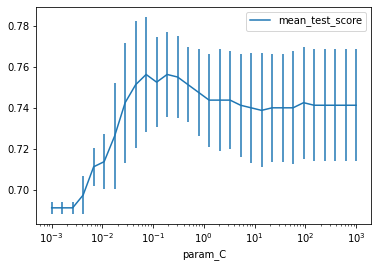

In [104]:
scores = pd.DataFrame(grid_lr.cv_results_)
plt.xscale('log')
scores.plot(x='param_C', y='mean_test_score', yerr='std_test_score', ax=plt.gca())

In [293]:
grid_lr.best_params_

{'C': 0.3039195382313198}

## LinearSVC

In [294]:
import warnings
warnings.filterwarnings('ignore')

param_grid_svc = {'C' : np.logspace(-3, 3, 30)}

grid_svc = GridSearchCV(svc, param_grid_svc, return_train_score=True)
grid_svc.fit(X_train, y_train)
grid_svc.score(X_test, y_test)

0.765

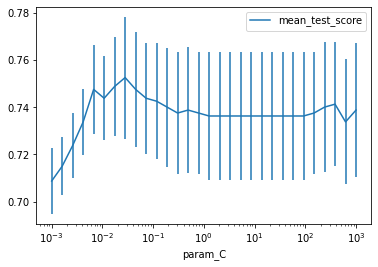

In [295]:
scores = pd.DataFrame(grid_svc.cv_results_)
plt.xscale('log')
scores.plot(x='param_C', y='mean_test_score', yerr='std_test_score', ax=plt.gca())

In [296]:
grid_svc.best_params_

{'C': 0.02807216203941177}

## Random Forest

In [115]:
param_grid_rf = {'n_estimators' : range(10, 100, 4)}

grid_rf = GridSearchCV(rf, param_grid_rf)
grid_rf.fit(X_train, y_train)
grid_rf.score(X_test, y_test)

0.77

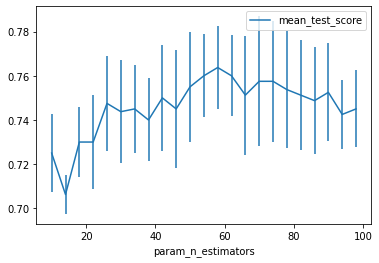

In [116]:
scores = pd.DataFrame(grid_rf.cv_results_)
scores.plot(x='param_n_estimators', y='mean_test_score', yerr='std_test_score', ax=plt.gca())

In [297]:
grid_rf.best_params_

{'n_estimators': 58}

grid search를 통해 더 많은 파라미터를 조정할 수도 있을 것이고, 내가 찾은 최적의 파라미터보다 더 나은 파라미터가 존재할 수도 있다. 그러나 이 정도의 gridsearch만으로도 score가 향상되었음은 확인할 수 있다.

# **Q6**
## Change the cross-validation strategy from ‘stratified k-fold’ to ‘kfold’ with shuffling. 
## Do the parameters that are found change? Do they change if you change the random seed of the shuffling? Or if you change the random state of the split into training and test data?

In [317]:
lr = LogisticRegression(max_iter=1000, random_state=123)
svc = LinearSVC(max_iter=100000, random_state=123)
rf = RandomForestClassifier(random_state=123)

In [318]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train = preprocessor_scale.fit_transform(X_train)
X_test = preprocessor_scale.transform(X_test)

In [319]:
X_train.shape, X_test.shape

((800, 61), (200, 61))

In [320]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)

### model eval with KFold

In [321]:
param_grid_lr = {'C' : np.logspace(-3, 3, 30)}
param_grid_svc = {'C' : np.logspace(-3, 3, 30)}
param_grid_rf = {'n_estimators' : range(10, 100, 4)}

grid_lr = GridSearchCV(lr, param_grid_lr, cv=cv)
grid_lr.fit(X_train, y_train)

grid_svc = GridSearchCV(svc, param_grid_svc, cv=cv)
grid_svc.fit(X_train, y_train)

grid_rf = GridSearchCV(rf, param_grid_rf, cv=cv)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=123, shuffle=True),
             estimator=RandomForestClassifier(random_state=123),
             param_grid={'n_estimators': range(10, 100, 4)})

In [328]:
# random state of split = 100, random state of shuffle = 100
#0.745 0.76 0.785
#{'C': 0.18873918221350977} {'C': 0.04520353656360243} {'n_estimators': 66}

# random state of split = 123, random state of shuffle = 123
print(grid_lr.score(X_test, y_test), grid_svc.score(X_test, y_test), grid_rf.score(X_test, y_test))
print(grid_lr.best_params_, grid_svc.best_params_, grid_rf.best_params_)

0.78 0.785 0.77
{'C': 0.11721022975334805} {'C': 3.2903445623126677} {'n_estimators': 50}


동일한 조건 (random state of split = 100, random state of shuffle = 100)
일때, stratified k-fold 와 kfold에서 best paramter의 값이 조금씩 다르다.

k-fold에서, split과 shuffle의 random state값을 변화시켰을 때도, 결과가 다르게 나왔다.

# **Q7**
## Visualize the 20 most important coefficients for Logistic Regression and Linear Support Vector Machines using hyper-parameters that performed well in the grid-search.

In [329]:
hp_lr = grid_lr.best_params_
hp_svc = grid_svc.best_params_
hp_rf = grid_rf.best_params_
hp_lr, hp_svc, hp_rf

({'C': 0.11721022975334805}, {'C': 3.2903445623126677}, {'n_estimators': 50})

In [330]:
lr_best = LogisticRegression(max_iter=1000, C=hp_lr['C'], random_state=123)
svc_best = LinearSVC(max_iter=100000, C=hp_svc['C'], random_state=123)

In [331]:
lr_best.fit(X_train, y_train)
svc_best.fit(X_train, y_train)

LinearSVC(C=3.2903445623126677, max_iter=100000, random_state=123)

In [332]:
lr_mi_coef_ = np.sort(lr_best.coef_[0])[::-1][:20]
svc_mi_coef_ = np.sort(svc_best.coef_[0])[::-1][:20]
print(lr_mi_coef_)
print(svc_mi_coef_)

[0.75181104 0.55660263 0.50616055 0.39279728 0.30899973 0.24177243
 0.23202264 0.22716276 0.22561624 0.21331933 0.20960711 0.19428543
 0.17250031 0.15362319 0.14088707 0.12773886 0.11388542 0.10108739
 0.09644722 0.0591367 ]
[1.01001631 0.34423313 0.31897621 0.27863778 0.26954286 0.26632291
 0.23306572 0.22568635 0.21891377 0.20437437 0.19139804 0.1595804
 0.15654831 0.12549613 0.11526561 0.11052843 0.10571456 0.08982107
 0.08878357 0.07883139]


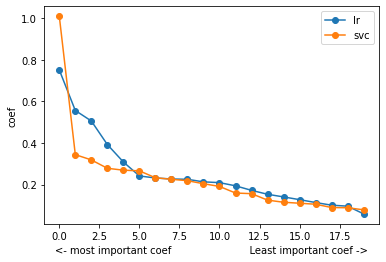

In [333]:
x_values = range(0, 20)
plt.plot(x_values, lr_mi_coef_, marker='o')
plt.plot(x_values, svc_mi_coef_, marker='o')
plt.ylabel('coef')
plt.xlabel('<- most important coef                         Least important coef ->')
plt.legend(['lr', 'svc'])
plt.show()

# **Q8**
## Using optimized models that performed well in the grid-search, compute the performance of all three models using confusion matrix, precision, recall, and F1-score. 
## How different are the results? Also, calculate the true positive rate and false positive rate for all three models. Discuss the results. 

In [345]:
y_pred1 = lr_best.predict(X_test)
y_pred2 = svc_best.predict(X_test)
y_pred3 = rf_best.predict(X_test)

for y_pred in [y_pred1, y_pred2, y_pred3]:
    print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         bad       0.66      0.57      0.61        61
        good       0.82      0.87      0.85       139

    accuracy                           0.78       200
   macro avg       0.74      0.72      0.73       200
weighted avg       0.77      0.78      0.78       200

              precision    recall  f1-score   support

         bad       0.66      0.61      0.63        61
        good       0.83      0.86      0.85       139

    accuracy                           0.79       200
   macro avg       0.75      0.73      0.74       200
weighted avg       0.78      0.79      0.78       200

              precision    recall  f1-score   support

         bad       0.68      0.46      0.55        61
        good       0.79      0.91      0.85       139

    accuracy                           0.77       200
   macro avg       0.74      0.68      0.70       200
weighted avg       0.76      0.77      0.76       200



lr와 svc 모델은 precision, recall 모두 비슷한 performance를 보이고 있다.
rf 모델은 bad클래스를 recall하는데는 조금 성능이 낮지만, 오히려 good을 recall하는데는 다른 모델들보다 좋은 성능을 보이고 있다.
즉, rf모델은 (good = positive) credit이 good인 사람을 발견하지 못할 확률이 적다고 말할 수 있다.

good을 positive로 정하면, true positive rate 는 recall과 같다.
즉, lr의 TPR = 0.87, svc의 TPR = 0.86, rf의 TPR = 0.91

false positive rate (FPR) = 1 - true negative rate (TNR) 이다.
TNR는 다시말하면 negative, 즉 bad의 recall능력과 같다.
따라서, lr의 FPR = 1 - 0.57 = 0.43, 같은 방법으로 svc의 FPR = 0.39, rf의 FPR = 0.54 이다.

# **Q9**
## Plot precision-recall (PR) curve and receiver operating characteristics (ROC) curve for all three models. 
## Also, compute the performance of all three models using average precision and area under the curve (AUC). Discuss the results.

In [344]:
rf_best = RandomForestClassifier(n_estimators=hp_rf['n_estimators'], random_state=123)
rf_best.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=123)

### Precision-Recall

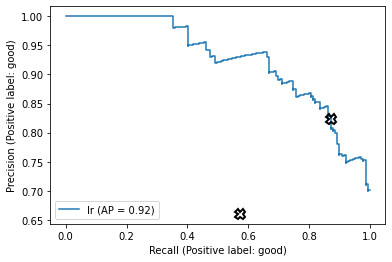

In [374]:
pr_lr = plot_precision_recall_curve(lr_best, X_test, y_test, name='lr')
p_lr , r_lr, _, _ = precision_recall_fscore_support(lr_best.predict(X_test), y_test)

plt.plot(p_lr, r_lr, 'X', markersize=10, label='threshold zero', fillstyle='none', c='k', mew=2)
plt.show()

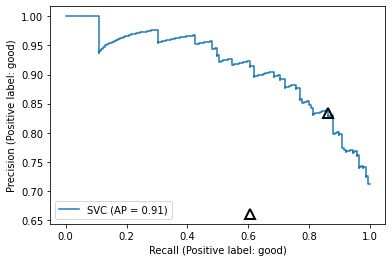

In [375]:
pr_svc = plot_precision_recall_curve(svc_best, X_test, y_test, name='SVC')
p_svc, r_svc, _, _ = precision_recall_fscore_support(svc_best.predict(X_test), y_test)

plt.plot(p_svc, r_svc, '^', markersize=10, label="threshold zero", fillstyle="none", c='k', mew=2)
plt.show()

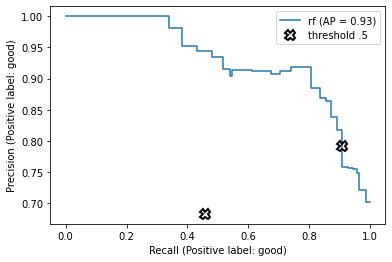

In [376]:
pr_rf = plot_precision_recall_curve(rf_best, X_test, y_test, name='rf')
p_rf , r_rf, _, _ = precision_recall_fscore_support(rf_best.predict(X_test), y_test)
plt.plot(p_rf, r_rf, 'X', markersize=10, label='threshold .5', fillstyle='none', c='k', mew=2)
plt.legend()

### ROC curve

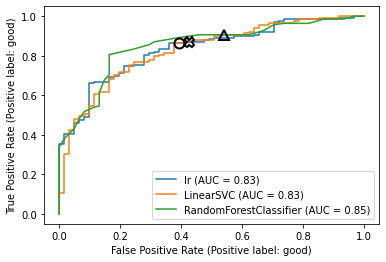

In [380]:
confusion_lr = confusion_matrix(y_test, lr_best.predict(X_test), normalize='true')
confusion_svc = confusion_matrix(y_test, svc_best.predict(X_test), normalize='true')
confusion_rf = confusion_matrix(y_test, rf_best.predict(X_test), normalize='true')

plot_roc_curve(lr_best, X_test, y_test, name='lr')
plot_roc_curve(svc_best, X_test, y_test, ax=plt.gca())
plot_roc_curve(rf_best, X_test, y_test, ax=plt.gca())

plt.plot(confusion_lr[0, 1], confusion_lr[1, 1], 'X', markersize=10,
         label="threshold zero SVC", fillstyle="none", c='k', mew=2)
plt.plot(confusion_svc[0, 1], confusion_svc[1, 1], 'o', markersize=10,
         label="threshold zero SVC", fillstyle="none", c='k', mew=2)
plt.plot(confusion_rf[0, 1], confusion_rf[1, 1], '^', markersize=10,
         label="threshold 0.5 RF", fillstyle="none", c='k', mew=2)

### Avg precision

In [405]:
y_test_bin = [1 if elem == 'good' else 0 for elem in y_test]
lr_best_pred_bin = [1 if elem == 'good' else 0 for elem in lr_best.predict(X_test)]
rf_best_pred_bin = [1 if elem == 'good' else 0 for elem in rf_best.predict(X_test)]

In [406]:
from sklearn.metrics import average_precision_score
ap_lr = average_precision_score(y_test_bin, lr_best_pred_bin)
ap_rf = average_precision_score(y_test_bin, rf_best_pred_bin)
ap_svc = average_precision_score(y_test_bin, svc_best.decision_function(X_test))
print("Average precision of lr: {:.3f}".format(ap_lr))
print("Average precision of random forest: {:.3f}".format(ap_rf))
print("Average precision of svc: {:.3f}".format(ap_svc))

Average precision of lr: 0.807
Average precision of random forest: 0.783
Average precision of svc: 0.913


### AUC

In [410]:
# linearSVC모델은 predict_proba를 제공하지 않음.
from sklearn.calibration import CalibratedClassifierCV

clf = CalibratedClassifierCV(svc_best)
clf.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=LinearSVC(C=3.2903445623126677,
                                                max_iter=100000,
                                                random_state=123))

In [411]:
from sklearn.metrics import roc_auc_score

lr_pred_proba = lr_best.predict_proba(X_test)[:, 1]
lr_roc_score = roc_auc_score(y_test, lr_pred_proba)

svc_pred_proba = clf.predict_proba(X_test)[:, 1]
svc_roc_score = roc_auc_score(y_test, svc_pred_proba)

rf_pred_proba = rf_best.predict_proba(X_test)[:, 1]
rf_roc_score = roc_auc_score(y_test, rf_pred_proba)

print('lr의 ROC AUC 값: {0:.4f}'.format(lr_roc_score))
print('svc의 ROC AUC 값: {0:.4f}'.format(svc_roc_score))
print('rf의 ROC AUC 값: {0:.4f}'.format(rf_roc_score))

lr의 ROC AUC 값: 0.8345
svc의 ROC AUC 값: 0.8273
rf의 ROC AUC 값: 0.8502


AUC는 ROC곡선의 밑넓이이고, ROC곡선은 X축은 FPR, y축은 TPR이다.
TPR값이 크다는 것은, 전체 positive중 positive로 예측된 샘플의 비율이 높다는 것이고, 즉 모델의 예측성능이 좋다는 것이다.

반대로 FPR는 전체 negative 샘플중 positive로 잘못 예측된 샘플의 비율이므로, 낮을수록 좋다.

따라서, FPR값이 감소할때, TPR값이 적게 감소한다면 해당 모델은 좋은 분류성능을 가졌다고 생각할 수 있다.

그러므로, AUC값이 1에 가까울수록, FPR값의 감소에도 TPR이 거의 감소하지 않는다는 것이고 결국 모델의 성능이 좋다는것을 의미한다.

따라서, AUC값이 큰 순서대로 random forest, logistic regression, linearSVC의 순서대로 이진 분류 성능이 좋다고 볼 수 있다.